<head><h1 align="center">
Recipe Recommender System
</h1></head>  
  
<head><h3 align="center">Comprehensive (not Summative) Project Notebook</h3></head>  

Some of the most successful and well known companies in the world use recommender systems to deliver products, services & content. *Google* uses recommender systems to target advertising, while *Amazon* uses them to connect customers on the platform to items that are more relevant and likely to be purchased, given the customer's profile. *Netflix*, *YouTube*, and many others do the same for content so that we may spend more time on their platform, and yet, when it comes to particular categories of items which play a larger role in a person's every-day life, such systems appear to be less utilized.  
  
While food delivery services (*Seamless*, *Postmates*, & *GrubHub*) and applications for grocery delivery (*Instacart*, *Fresh Direct*, etc.) most certainly utilize user data to connect their customers with content that is curated to be more relevant for them, there has yet to be a service for food *recipes* that has become ubiquitous — that is, while there are many resources for a person to find recipes, no single resource has dominated the field.  
  
In developing a food recipe recommender system, I hope to empower individuals with a tool that will allow them to better curate their life. With this system, a user will be able to discover a vast world of recipes personalized to them.

### Setup

**Install Dependencies:**

In [9]:
# %pip install wordcloud
# %pip install surprise

**Import Settings,  
Libraries & Functions:**

In [3]:
# sys.path.insert(0, '/home/ec2-user/SageMaker/recipe-book/code/')
from code.functions import *
# from code.aws_connect import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Additional Dependencies for when working via AWS SageMaker

In [ ]:
# import sagemaker
# from sagemaker import get_execution_role # commented out for local
# from sagemaker.predictor import csv_serializer  commented out for local 


# Define IAM role
# role = get_execution_role()
# prefix = 'sagemaker/knn'
# containers = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/knn:1',
#               'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/knn:1',
#               'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/knn:1',
#               'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/knn:1',
#               'ap-northeast-1': '351501993468.dkr.ecr.ap-northeast-1.amazonaws.com/knn:1',
#               'ap-northeast-2': '835164637446.dkr.ecr.ap-northeast-2.amazonaws.com/knn:1',
#               'ap-southeast-2': '712309505854.dkr.ecr.ap-southeast-2.amazonaws.com/knn:1'}

# my_region = boto3.session.Session().region_name # set the region of the instance
# print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + containers[my_region] + " container for your SageMaker endpoint.")

# Data

In [11]:
# Datasets available online via my AWS S3 Bucket storage
# interactions_url = ('https://sagemaker-studio-t1ems8mtnoj.s3.us-east-2.amazonaws.com/RAW_interactions.csv')
# recipes_url = ('https://sagemaker-studio-t1ems8mtnoj.s3.us-east-2.amazonaws.com/RAW_recipes.csv')
# rdf = pd.read_csv(recipes_url)
# idf = pd.read_csv(interactions_url)

In [6]:
rdf = pd.read_csv('data/RAW_recipes.csv')
idf = pd.read_csv('data/RAW_interactions.csv')

## Cleaning & Data Preparation

In [7]:
# Cleaning: Dropping row that contains a NaN value for recipe name
rdf.drop(labels=721, inplace = True)

# Cleaning/FE: Creating columns for recipe's respective nutrients
rdf['kcal'] = rdf.nutrition.apply(lambda x: x[1:-1].split(sep=', ')[0])
rdf['fat'] = rdf.nutrition.apply(lambda x: x[1:-1].split(sep=', ')[1])
rdf['sugar'] = rdf.nutrition.apply(lambda x: x[1:-1].split(sep=', ')[2])
rdf['salt'] = rdf.nutrition.apply(lambda x: x[1:-1].split(sep=', ')[3])
rdf['protein'] = rdf.nutrition.apply(lambda x: x[1:-1].split(sep=', ')[4])
rdf['sat_fat'] = rdf.nutrition.apply(lambda x: x[1:-1].split(sep=', ')[5])
rdf['carbs'] = rdf.nutrition.apply(lambda x: x[1:-1].split(sep=', ')[6])

# Cleaning: Imputing outlier value to median
rdf['minutes'] = np.where(rdf.minutes == 2147483647,
                         rdf.minutes.median(),
                         rdf.minutes)

idf['date'] = pd.to_datetime(idf.date)

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
sidf = Dataset.load_from_df(idf[['user_id', 'recipe_id', 'rating']], reader)

In [8]:
rdf

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,kcal,fat,sugar,salt,protein,sat_fat,carbs
0,arriba baked winter squash mexican style,137739,55.0,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'north-american', 'side-dishes', 'vegetables', 'mexican', 'easy', 'fall', 'holiday-event',...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'depending on size of squash , cut into half or fourths', 'remove seeds', 'for spicy squash , drizzle olive oil or melted butter over each cut squash piec...","autumn is my favorite time of year to cook! this recipe \r\ncan be prepared either spicy or sweet, your choice!\r\ntwo of my posted mexican-inspired seasoning mix recipes are offered as suggestions.","['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']",7,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,a bit different breakfast pizza,31490,30.0,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'north-american', 'breakfast', 'main-dish', 'pork', 'american', 'oven', 'easy', 'kid-frien...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough into the bottom and sides of a 12 inch pizza pan', 'bake for 5 minutes until set but not browned', 'cut sausage into small pieces', 'whisk eggs and m...",this recipe calls for the crust to be prebaked a bit before adding ingredients. feel free to change sausage to ham or bacon. this warms well in the microwave for those late risers.,"['prepared pizza crust', 'sausage patty', 'eggs', 'milk', 'salt and pepper', 'cheese']",6,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,all in the kitchen chili,112140,130.0,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'main-dish', 'chili', 'crock-pot-slow-cooker', 'dietary', 'equipment', '4-hours-or-less']","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add chopped onions to ground beef when almost brown and sautee until wilted', 'add all other ingredients', 'add kidney beans if you like beans in your chili', '...",this modified version of 'mom's' chili was a hit at our 2004 christmas party. we made an extra large pot to have some left to freeze but it never made it to the freezer. it was a favorite by all. ...,"['ground beef', 'yellow onions', 'diced tomatoes', 'tomato paste', 'tomato soup', 'rotel tomatoes', 'kidney beans', 'water', 'chili powder', 'ground cumin', 'salt', 'lettuce', 'cheddar cheese']",13,269.8,22.0,32.0,48.0,39.0,27.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231634,zydeco ya ya deviled eggs,308080,40.0,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'preparation', 'appetizers', 'eggs-dairy', 'easy', 'finger-food', 'eggs', 'presentation', 'served-cold', '3-steps-or-less']","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and mayonnaise', 'stir in the mustard', 'stir in the cajun seasoning and tabasco', 'taste , then season with salt and pepper', 'fill the whites evenly with t...","deviled eggs, cajun-style","['hard-cooked eggs', 'mayonnaise', 'dijon mustard', 'salt-free cajun seasoning', 'tabasco sauce', 'salt', 'black pepper', 'fresh italian parsley']",8,59.2,6.0,2.0,3.0,6.0,5.0,0.0
231635,cookies by design cookies on a stick,298512,29.0,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course', 'preparation', 'for-large-groups', 'hand-formed-cookies', 'desserts', 'cookies-and-brownies', 'dietary', 'high-calcium', 'high-in-something', 'numb...","[188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]",9,"['place melted butter in a large mixing bowl and add each remaining ingredient as listed , beating well after each addition to achieve a smooth dough', 'let dough stand uncovered 10 minutes', 'mak..

## About the Dataset

**<u>Food.com Recipes and Interactions Dataset</u>**  

The csv containing interactions data comes with **1,132,367 rows** of user ratings and reviews of different recipes.  
The csv containing data relating to the recipes comes with **231,636 rows** of different recipes.
>This dataset consists of **180K+ recipes** and **700K+ recipe reviews** covering 18 years of user interactions and uploads on *Food.com* (formerly *GeniusKitchen*) used in the paper listed below under section:  
> - [**Resources**](https://recipe-book-github-t2-exec.notebook.us-east-2.sagemaker.aws/notebooks/recipe-book/MF_Recipe_RecSystem_Notebook.ipynb#Resources)  
>  - ***Food.com Recipes and Interactions* — Full Description/**  
>    - **Acknowledgements**

This dataset contains what can be considered three different "sets" of data from *Food.com*:  
  
**Raw data files**  
- `RAW_interactions.csv` — A CSV file containing data on individual user interactions (rating, review, and date of interaction) with different recipes.
- `RAW_recipes.csv` — A CSV file containing data on the recipes referenced in the interactions data file by their ID.
- `ingr_map.pkl` — Pickle file containing a map of recipe ingredients tokens to their corresponding ingredient.

**Interaction splits**

- `interactions_test.csv`
- `interactions_validation.csv`
- `interactions_train.csv`
  
**Preprocessed data for result reproduction**  
In this format, the recipe text metadata is tokenized via the GPT subword tokenizer with start-of-step, etc. tokens.

- `PP_recipes.csv`
- `PP_users.csv`
  
Note from the dataset contributor regarding the `u` and `i` features in the pre-processed data files:  
> `u` and `i` are contiguous integer IDs for users and recipes, respectively. These are contiguous so you can use them for tensor/array indexing.  
  
> To convert these files into the `pickle` format required to run our code off-the-shelf, you may use `pandas.read_csv` and `pandas.to_pickle` to convert the CSV's into the proper `pickle` format.  
  
**My Enginered Data**  
I have created the following data files from the aforementioned dataset files:
- `ui_ratings.csv` — A simplified version of `RAW_interactions.csv` created in an attempt to facilitate a successful modeling process (i.e.: reduce memory consumption)

# EDA

## RAW Interactions Data — `idf`

Represent user reviews and ratings for different recipes  
- Interactions Train Set Total Rows: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**698,901**  
  Interactions Val. Set Total Rows: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **7,023**  
  Interactions Test Set Total Rows: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **12,455**  
  ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾ ‾   
  Combined Train/ Val/ Test Sets: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**718,379**  
  **Raw Interactions Set Total Rows:** &nbsp;&nbsp;**1,132,367**  
  ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾  
    
The only null values in the dataset are in the `review` column, where users rated a recipe but did not leave a review comment. Even still, there are only **169** rows (representing user interactions) where this is the case — which is only roughly $\frac{1}{15,000}$ of the total data.  
  
Also to note, I'm not even sure if dropping these null values is necessary, as the `review` feature will not be used for the utility matrix/collaborative-filtering model. It would be worthwhile to reevaluate when I implement natural language processing.

In [15]:
idf.rating.value_counts()

5    816364
4    187360
0     60847
3     40855
2     14123
1     12818
Name: rating, dtype: int64

In [16]:
idf.describe()

,user_id,recipe_id,rating
count,1.132367e+06,1.132367e+06,1.132367e+06
mean,1.384291e+08,1.608972e+05,4.411016e+00
std,5.014269e+08,1.303987e+05,1.264752e+00
min,1.533000e+03,3.800000e+01,0.000000e+00
25%,1.354700e+05,5.425700e+04,4.000000e+00
50%,3.309370e+05,1.205470e+05,5.000000e+00
75%,8.045500e+05,2.438520e+05,5.000000e+00
max,2.002373e+09,5.377160e+05,5.000000e+00


In [9]:
idf.isna().sum()

user_id        0
recipe_id      0
date           0
rating         0
review       169
dtype: int64

In [5]:
4.411016e+00

4.411016

In [6]:
1.132367e+06

1132367.0

In [7]:
169/len(idf)

0.00014924490028409517

In [8]:
169/len(idf)

0.00014924490028409517

### `user_id`

>User ID of the interacting user leaving a review and rating.
  
- **226,570 unique** user IDs out of **1,132,367 total** recipe rating/review interactions.
- $83.4\%$ of users have had **no more than 2 interactions** on the site.

In [43]:
len(idf.user_id.unique())

226570

Text(0.5, 0.75, 'Top 35 Most Interactive Users')

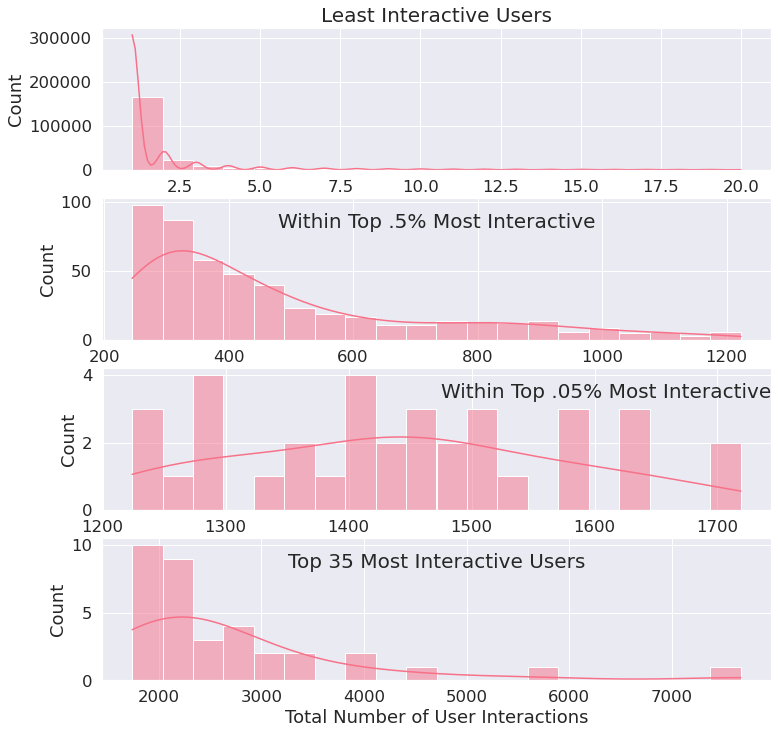

In [20]:
sns.set_palette("husl", 2) 
fig, ax = plt.subplots(4, 1, figsize=(12,12))
sns.histplot(idf.user_id.value_counts().sort_values()[:220000], bins = 20, kde='true', ax=ax[0])
sns.histplot(idf.user_id.value_counts().sort_values()[226000:226500], bins = 20, kde='true', ax=ax[1])
sns.histplot(idf.user_id.value_counts().sort_values()[226500:226535], bins = 20, kde=True, ax=ax[2])
sns.histplot(idf.user_id.value_counts().sort_values()[226535:], bins = 20, kde=True, ax=ax[3])
ax[0].set_xlabel(xlabel=None)
ax[1].set_xlabel(xlabel=None)
ax[2].set_xlabel(xlabel=None)
ax[3].set_xlabel(xlabel='Total Number of User Interactions')

ax[0].set_title(label='Least Interactive Users', size = 20)
ax[1].set_title(label='Within Top .5% Most Interactive', size = 20, y=.750)
ax[2].set_title(label='Within Top .05% Most Interactive', size = 20, y=.750, loc='right')
ax[3].set_title(label='Top 35 Most Interactive Users', size = 20, y=.750)

# ax[0].set_yticklabels(labels=size = 16)
# ax[1].set_yticklabels(size = 16)
# ax[2].set_yticklabels(size = 16)
# ax[2].set_yticklabels(size = 16);

In [15]:
(idf.user_id.value_counts().values < 3).sum()

188994

In [16]:
188994/226570

0.8341528004590193

In [17]:
idf.user_id.value_counts()[:5000].tail()

748089     27
990914     27
246695     27
1320681    27
493747     27
Name: user_id, dtype: int64

In [18]:
idf.user_id.value_counts().sort_values(ascending=False)

424680        7671
37449         5603
383346        4628
              ... 
2001280864       1
1824864          1
4317             1
Name: user_id, Length: 226570, dtype: int64

In [20]:
idf.user_id

0               38094
1             1293707
2                8937
              ...    
1132364        157126
1132365         53932
1132366    2001868099
Name: user_id, Length: 1132367, dtype: int64

### `recipe_id`

- There are **231,637 total unique recipes**.
- A large amount (**91,953**) of recipes **have only 1 interaction**, and a majority  have only 1 or 2 interactions (**137,073**, or **59% of all unique recipes**).
- There are mysterious occurrences where certain recipes have **0 interactions**.

In [21]:
(idf.recipe_id.value_counts() == 0).sum()

0

In [22]:
(idf.recipe_id.value_counts() == 1).sum()

91953

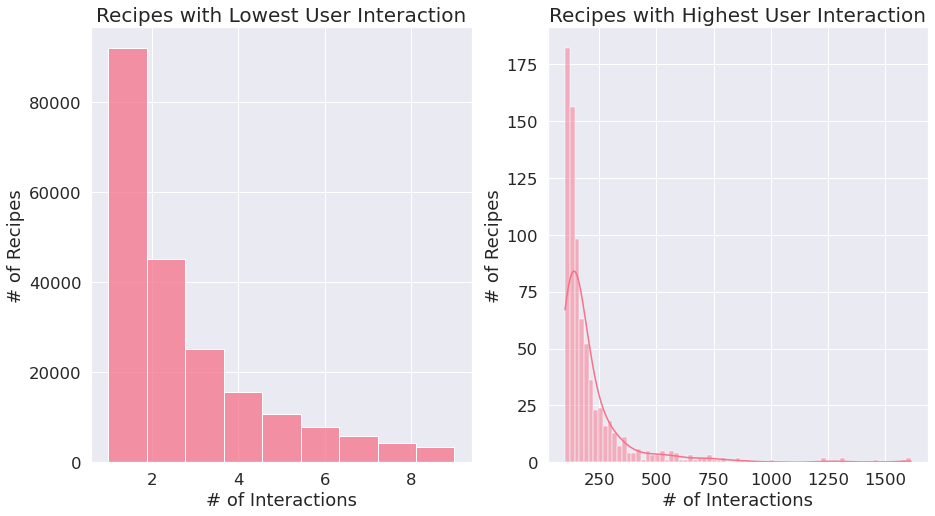

In [61]:
fig, ax = plt.subplots(1,2, figsize=(15, 8), sharey=False)
sns.histplot(x=idf.recipe_id.value_counts().sort_values()[:210238], bins= 9, ax=ax[0])
sns.histplot(x=idf.recipe_id.value_counts().sort_values(ascending=False)[:770], kde=True, ax=ax[1])
ax[0].set_xlabel(xlabel='# of Interactions')
ax[1].set_xlabel(xlabel='# of Interactions')

ax[0].set_ylabel(ylabel='# of Recipes')
ax[1].set_ylabel(ylabel='# of Recipes')

ax[0].set_title(label='Recipes with Lowest User Interaction', size = 20)
ax[1].set_title(label='Recipes with Highest User Interaction', size = 20);

In [51]:
137073/len(idf.recipe_id.unique())

0.5917577934440525

In [50]:
(idf.recipe_id.value_counts() < 3).sum()

137073

In [56]:
(idf.recipe_id.value_counts() < 10).sum()

210238

In [58]:
idf.recipe_id.value_counts().sort_values()[:210238]

4098      1
52005     1
35629     1
         ..
306156    9
469200    9
141801    9
Name: recipe_id, Length: 210238, dtype: int64

In [26]:
(idf.recipe_id.value_counts() < 100).sum() # 230,850 recipes with less than 100 interactions
(idf.recipe_id.value_counts() > 100).sum() # 769 recipes with more than 100 interactions
(idf.recipe_id.value_counts() > 1000).sum() # 8 recipes with more than 1,000 interactions

230850

In [24]:
((idf.recipe_id.value_counts() > 100) & (idf.recipe_id.value_counts() < 500)).sum()

721

In [25]:
((idf.recipe_id.value_counts() > 500) & (idf.recipe_id.value_counts() < 1000)).sum()

40

In [26]:
((idf.recipe_id.value_counts() > 100) & (idf.recipe_id.value_counts() < 1000)).sum()

761

### `date`

The date of the row's event (user interaction).  
There are **6,396 total dates** in the sample in which interactions are recorded. The data spans interactions that take place over the course of approximately **19 years**.  
- The earliest date on record in the sample is **January 25, 2000**.
- The final date on record in the sample is **December 20, 2018**.

The wild variance in the lineplot below is caused by a large increase in user rating/review interactions after 2002.  
- between **2000-2002**, there are only **3012 total interactions**
- between **2002-2003**, there are **20922 total interactions**. 
- the interactions from the sample continue to increase until a peak around 2008.

In [42]:
idf.date.max()

Timestamp('2018-12-20 00:00:00')

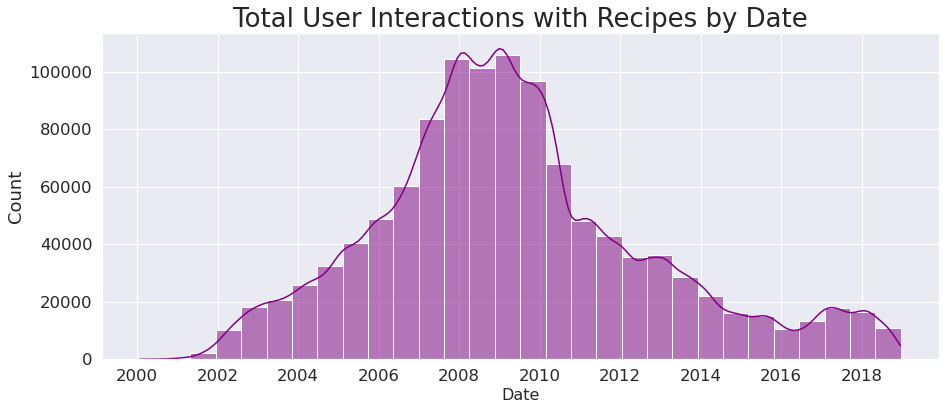

In [99]:
sns.set_palette('Pastel1')#, 1) 
fig, ax = plt.subplots(figsize=(15,6))
sns.histplot(x=idf.date, bins = 30, kde=True, color='purple')
ax.set_xlabel(xlabel='Date', size=16)
ax.set_title(label='Total User Interactions with Recipes by Date', size = 26)
plt.savefig('images/total_user_interactions_A.png', transparent=True);

''

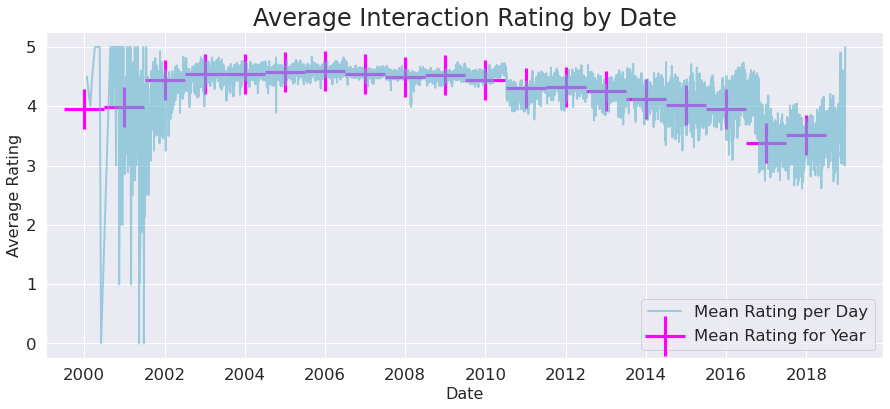

In [97]:
yearly_rating_avg = [idf[(idf['date'] >= '2000-01-25') & (idf['date'] <= '2000-12-31')].rating.mean(),
                     idf[(idf['date'] >= '2001-01-01') & (idf['date'] <= '2001-12-31')].rating.mean(),
                     idf[(idf['date'] >= '2002-01-01') & (idf['date'] <= '2002-12-31')].rating.mean(),
                     idf[(idf['date'] >= '2003-01-01') & (idf['date'] <= '2003-12-31')].rating.mean(),
                     idf[(idf['date'] >= '2004-01-01') & (idf['date'] <= '2004-12-31')].rating.mean(),
                     idf[(idf['date'] >= '2005-01-01') & (idf['date'] <= '2005-12-31')].rating.mean(),
                     idf[(idf['date'] >= '2006-01-01') & (idf['date'] <= '2006-12-31')].rating.mean(),
                     idf[(idf['date'] >= '2007-01-01') & (idf['date'] <= '2007-12-31')].rating.mean(),
                     idf[(idf['date'] >= '2008-01-01') & (idf['date'] <= '2008-12-31')].rating.mean(),
                     idf[(idf['date'] >= '2009-01-01') & (idf['date'] <= '2009-12-31')].rating.mean(),
                     idf[(idf['date'] >= '2010-01-01') & (idf['date'] <= '2010-12-31')].rating.mean(),
                     idf[(idf['date'] >= '2011-01-01') & (idf['date'] <= '2011-12-31')].rating.mean(),
                     idf[(idf['date'] >= '2012-01-01') & (idf['date'] <= '2012-12-31')].rating.mean(),
                     idf[(idf['date'] >= '2013-01-01') & (idf['date'] <= '2013-12-31')].rating.mean(),
                     idf[(idf['date'] >= '2014-01-01') & (idf['date'] <= '2014-12-31')].rating.mean(),
                     idf[(idf['date'] >= '2015-01-01') & (idf['date'] <= '2015-12-31')].rating.mean(),
                     idf[(idf['date'] >= '2016-01-01') & (idf['date'] <= '2016-12-31')].rating.mean(),
                     idf[(idf['date'] >= '2017-01-01') & (idf['date'] <= '2017-12-31')].rating.mean(),
                     idf[(idf['date'] >= '2018-01-01') & (idf['date'] <= '2018-12-20')].rating.mean()]

years = list(range(2000, 2019, 1))
yrs = []
for i in years:
    yrs.append(str(i)+'-01-01')
yr_avg = {yrs[i]: yearly_rating_avg[i] for i in range(len(yrs))}
y_avg_df = pd.DataFrame.from_dict(yr_avg, orient='index', columns=['avg'])

yr_avg = {yrs[i]: yearly_rating_avg[i] for i in range(len(yrs))}
y_avg_df = pd.DataFrame.from_dict(yr_avg, orient='index', columns=['avg'])
y_avg_df = pd.DataFrame.from_dict(yr_avg, orient='index', columns=['avg'])

x = idf.groupby('date')['rating'].mean().sort_index()
sns.set_palette('Pastel1') 
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(x=x.index, y=x.values, color = 'c', linewidth=2, alpha=.6)
sns.scatterplot(x=pd.to_datetime(y_avg_df.index), y=y_avg_df['avg'], marker='+', s=1550, color='magenta', alpha=1) #scatter_kws={'color':"green"})
ax.set_xlabel(xlabel='Date', size=16)
ax.set_title(label='Average Interaction Rating by Date', size = 24)
ax.set_ylabel(ylabel='Average Rating', size=16)
ax.legend(['Mean Rating per Day', 'Mean Rating for Year'])
# plt.savefig('images/mean_rating_by_date_A.png', transparent=True)
;

In [100]:
# idf[(idf['date'] >= '2000-01-25') & (idf['date'] <= '2000-12-31')]
idf.date.count() # 1,132,367 unique days of interactions

1132367

In [23]:
idf.date.value_counts()

2008-01-27    723
2008-01-02    695
2008-06-30    692
2009-01-10    689
2008-01-06    688
             ... 
2000-11-06      1
2001-05-17      1
2000-12-19      1
2001-03-26      1
2000-10-23      1
Name: date, Length: 6396, dtype: int64

In [37]:
idf[idf.date < '2003'].date.value_counts().sum()-idf[idf.date < '2002'].date.value_counts().sum()

20922

In [40]:
idf[idf.date < '2004'].date.value_counts().sum()-idf[idf.date < '2003'].date.value_counts().sum()

32961

In [38]:
idf[idf.date < '2003'].date.value_counts().sum()

23934

In [39]:
idf[idf.date < '2002'].date.value_counts().sum()

3012

### `rating`

> Represents the user's rating for the recipe

Ratings of **5** are far and away the dominant class of the dataset. This disparity will be managed with weights.  
  
Further, we must consider what to do with ratings of **0**.  
  
For a recommender system, it would be easiest to simply drop zero values. The only method of imputation that would be useful would involve a sort of *Natural Language Processing*... which is to say that we would need to see how **implicit** characteristics of different recipes can be interpreted based on the word's interpreted value in **latent space**.

In [10]:
idf[idf.rating == 5].value_counts().sum()

816229

In [9]:
idf[idf.rating == 0].value_counts().sum()

60847

''

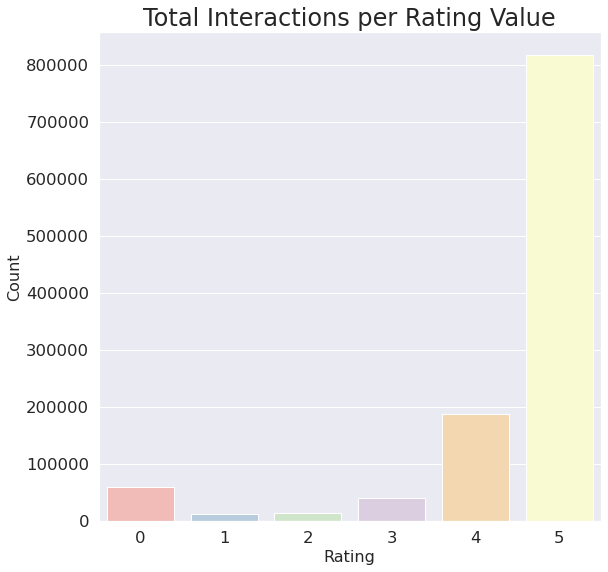

In [48]:
x = idf.rating.value_counts().sort_index()
sns.set_palette('Pastel1')
fig, ax = plt.subplots(figsize=(9,9))
sns.barplot(x=x.index, y=x.values)
ax.set_xlabel(xlabel='Rating', size=16)
ax.set_title(label='Total Interactions per Rating Value', size = 24)
ax.set_ylabel(ylabel='Count', size=16)
plt.savefig('images/ratingcounts_A.png', transparent=True)
;

In [38]:
idf.rating.value_counts()

5    816364
4    187360
0     60847
3     40855
2     14123
1     12818
Name: rating, dtype: int64

In [39]:
idf.rating.describe()

count    1.132367e+06
mean     4.411016e+00
std      1.264752e+00
             ...     
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, Length: 8, dtype: float64

In [ ]:
idf.rating.values

### `review`

> Represents the user's review comment for the recipe  
  
- Contains 169 Null Values  
  - All user interactions with null review have a **non-null *and* non-zero** rating.
- Could be used for a NLP 
- Showing a word cloud in presentation would be cool

In [150]:
idf[idf.review.isna() == True].rating.value_counts()

5    135
4     27
3      3
1      3
2      1
Name: rating, dtype: int64

In [151]:
idf[(idf.review.isna() == True) & (idf.rating == 0)]

,user_id,recipe_id,date,rating,review


In [152]:
169/len(idf)

0.00014924490028409517

**Dominant Words in Recipes with a review of 5:**

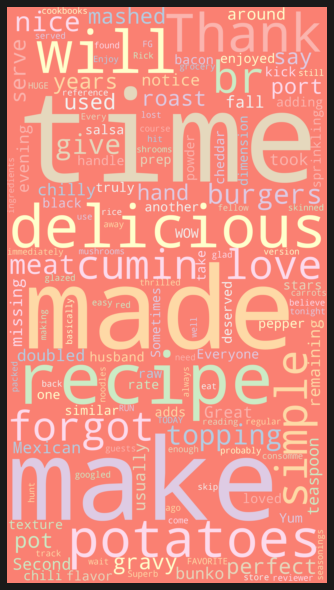

In [160]:
text = idf[idf.rating == 5].review.values
wordcloud = WordCloud(
    width = 2000,
    height = 3600,
    background_color = 'salmon',
    colormap = 'Pastel1',
    collocations = 'False', # False excludes bigrams
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (5, 8),
    facecolor = 'k',
    edgecolor = 'salmon')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('images/rating_high_words.png')
plt.show()

**Dominant Words for all Recipes:**

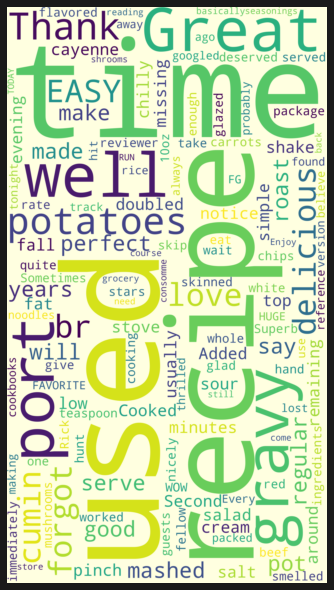

In [109]:
text = idf.review.values
wordcloud = WordCloud(
    width = 2000,
    height = 3600,
    background_color = 'lightyellow',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (5, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('images/rating_all_words.png')
plt.show()

**Dominant Words in Recipes with a review of 1 or 2:**

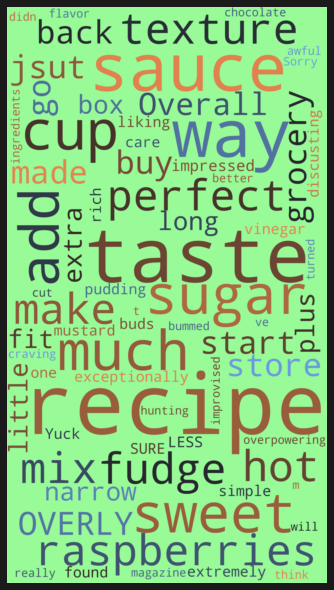

In [111]:
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
text = idf[(idf.rating > 0) & (idf.rating < 3)].review.values
wordcloud = WordCloud(
    width = 2000,
    height = 3600,
    background_color = 'palegreen',
    colormap = cmap,
    collocations = 'False', # False excludes bigrams
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (5, 8),
    facecolor = 'k',
    edgecolor = 'darkgreen')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('images/rating_low_words.png')
plt.show()

### Hypothesis Testing

Can we identify if there are recipes that increase the number of a user's interactions on the site?  
  
Also, would there be a way to control for a recipe promotion? i.e.—a recipe advertised on *Food.com*'s homepage would almost certainly drive more user interaction than those that are not.

would need to look at:  
- `int_df.date`  
- mean interaction frequency 

Alternatively, we could evaluate:  
- mean number of interactions for all users after interactions with recipes with a rating of 5 vs. the rest  
- mean number of interactions for all users after interactions with recipes with a rating of 5 vs. *mean number of interactions before*  
  
  For both of the above, we can evaluate **frequency**, **length of time that the user remained active on the site**.

 $µ$ 

## RAW Recipes Data — `rdf`

- The RAW Recipes dataset has **231,637** total rows, with each row representing a unique recipe submission on *Food.com*  
  \* (though there appear to be **1,451** rows that share recipe `name`s in common with other rows).  
- The difference in size between RAW recipes dataset and the PP recipes dataset (size 178,265) is **53,372**.

In [112]:
x = rdf.contributor_id.value_counts()
x[x>5]

89831      3118
37779      2553
37449      2493
           ... 
208755        6
141284        6
1281484       6
Name: contributor_id, Length: 4820, dtype: int64

In [133]:
rdf.head(1)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,kcal,fat,sugar,salt,protein,sat_fat,carbs
0,arriba baked winter squash mexican style,137739,55.0,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'north-american', 'side-dishes', 'vegetables', 'mexican', 'easy', 'fall', 'holiday-event',...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'depending on size of squash , cut into half or fourths', 'remove seeds', 'for spicy squash , drizzle olive oil or melted butter over each cut squash piec...","autumn is my favorite time of year to cook! this recipe \r\ncan be prepared either spicy or sweet, your choice!\r\ntwo of my posted mexican-inspired seasoning mix recipes are offered as suggestions.","['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']",7,51.5,0.0,13.0,0.0,2.0,0.0,4.0


In [134]:
rdf.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients', 'kcal', 'fat', 'sugar', 'salt', 'protein', 'sat_fat',
       'carbs'],
      dtype='object')

In [135]:
rdf.describe()

,id,minutes,contributor_id,n_steps,n_ingredients
count,231636.000000,2.316360e+05,2.316360e+05,231636.000000,231636.000000
mean,222014.077639,1.276459e+02,5.534906e+06,9.765516,9.051149
std,141206.613497,2.946343e+03,9.979162e+07,5.995136,3.734803
...,...,...,...,...,...
50%,207248.500000,4.000000e+01,1.736140e+05,9.000000,9.000000
75%,333815.250000,6.500000e+01,3.982750e+05,12.000000,11.000000
max,537716.000000,1.051200e+06,2.002290e+09,145.000000,43.000000


You can find the ingredient names in the RAW_recipes.csv file. I can't find the ingredient name-ID relationship, so you'll need to preprocess RAW_recipes.csv, generate PP_recipes.csv and the list of ingredient names

- The split 'interactions' datasets combined are only a portion of the full RAW interactions dataset. 
  - The difference between the RAW set and the other three combined is **413,988**.

### `name`

- 1 NaN value (**dropped**)
- **230,186** unique value (of 231,637 total)

In [136]:
len(rdf.name.unique()) # 230,186

230185

### `id`

### `minutes`

Recipe preparation/cook time.  
Values for recipe `minutes` contain outliers and/or dirtiness.  
- There are **9,970** recipes with values for `minutes` over 300 minutes.
- after review, at least [some](https://www.food.com/recipe/better-than-sex-strawberries-42198#activity-feed) of these are in fact accurate to the recipe.

FFS I'll never get this to plot. Try later with AWS.

In [137]:
len(rdf[rdf.minutes>300])

9969

In [138]:
# possibly the figure represents number of seconds?
18391/60 # high values to minutes: 306.5
18391/60/60 # high values to hours: 5.1

5.108611111111111

In [139]:
rdf[rdf.minutes > 300][0:1] # I'll have what she's having

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,kcal,fat,sugar,salt,protein,sat_fat,carbs
11,better than sex strawberries,42198,1460.0,41531,2002-10-03,"['weeknight', 'time-to-make', 'course', 'main-ingredient', 'preparation', 'occasion', 'low-protein', 'pies-and-tarts', 'desserts', 'fruit', '1-day-or-more', 'pies', 'dietary', 'low-sodium', 'comfo...","[734.1, 66.0, 199.0, 10.0, 10.0, 117.0, 28.0]",8,"['crush vanilla wafers into fine crumbs and line a square 8"" x8"" pan', 'mix butter or margarine and sugar', 'add beaten eggs', 'spread the mixture over the wafer crumbs', 'crush strawberries and s...","simple but sexy. this was in my local newspaper's food section. cook time reflects refrigeration time. i've been asked several times if this should be baked. just to clarify, no, it is not, it i...","['vanilla wafers', 'butter', 'powdered sugar', 'eggs', 'whipping cream', 'strawberry', 'walnuts']",7,734.1,66.0,199.0,10.0,10.0,117.0,28.0


In [140]:
rdf[rdf.minutes > 300]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,kcal,fat,sugar,salt,protein,sat_fat,carbs
11,better than sex strawberries,42198,1460.0,41531,2002-10-03,"['weeknight', 'time-to-make', 'course', 'main-ingredient', 'preparation', 'occasion', 'low-protein', 'pies-and-tarts', 'desserts', 'fruit', '1-day-or-more', 'pies', 'dietary', 'low-sodium', 'comfo...","[734.1, 66.0, 199.0, 10.0, 10.0, 117.0, 28.0]",8,"['crush vanilla wafers into fine crumbs and line a square 8"" x8"" pan', 'mix butter or margarine and sugar', 'add beaten eggs', 'spread the mixture over the wafer crumbs', 'crush strawberries and s...","simple but sexy. this was in my local newspaper's food section. cook time reflects refrigeration time. i've been asked several times if this should be baked. just to clarify, no, it is not, it i...","['vanilla wafers', 'butter', 'powdered sugar', 'eggs', 'whipping cream', 'strawberry', 'walnuts']",7,734.1,66.0,199.0,10.0,10.0,117.0,28.0
12,better then bush s baked beans,67547,2970.0,85627,2003-07-26,"['weeknight', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'north-american', 'side-dishes', 'beans', 'american', '1-day-or-more', 'oven', 'potluck', 'to-go', ...","[462.4, 28.0, 214.0, 69.0, 14.0, 29.0, 23.0]",9,"['in a very large sauce pan cover the beans and bouillon cubes in 3 inches of water', 'bring to a boil , cover , and let sit for 1 1 / 2 hours', 'preheat oven to 350 degrees f', ""drain and pour be...","i'd have to say that this is a labor of love dish, but i give you my word that this recipe is better than bush's. enjoy! oh, and also this recipe is easily doubled. in fact, i think it turns out b...","['great northern bean', 'chicken bouillon cubes', 'dark brown sugar', 'molasses', 'cornstarch', 'onion', 'garlic powder', 'mustard powder', 'chili powder', 'salt', 'black pepper', 'bacon', 'water']",13,462.4,28.0,214.0,69.0,14.0,29.0,23.0
13,boat house collard greens,107517,525.0,137696,2005-01-03,"['time-to-make', 'main-ingredient', 'preparation', 'vegetables', 'dietary', 'greens', 'collard-greens']","[315.8, 0.0, 202.0, 9.0, 6.0, 0.0, 21.0]",7,"['put prepared greens in large pot', 'add water', 'bring to a boil , and boil for one hour', 'add sugar , molasses , hot sauce , whiskey , and ham hock', 'bring to a boil again , and boil for anot...",my boss gave me this recipe several years ago. the recipe supposedly came from the,"['collard greens', 'brown sugar', 'molasses', 'hot sauce', 'whiskey', 'ham hock', 'salt']",7,315.8,0.0,202.0,9.0,6.0,0.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231355,zucchini salsa canned,462992,2900.0,1403860,2011-08-24,"['time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'for-large-groups', 'appetizers', 'vegetables', 'mexican', '1-day-or-more', 'easy', 'dips', 'number-of-servings', '3-steps-o...","[64.5, 0.0, 44.0, 53.0, 3.0, 0.0, 4.0]",27,"['day one: in a large bowl or stainless pan combine: zucchini', 'onions', 'green bell peppers', 'red bell peppers', 'jalapeno peppers', 'banana peppers', 'minced garlic', 'and 1 / 2 cup pickling s...",this is a delicious salsa recipe that my sister-in-law and i have adapted to a flavor combo that we like. it's thick and crunchy with fresh garden veggies. each bite will start with a slightly s...,"['zucchini', 'sweet white onions', 'green bell peppers', 'red bell peppers', 'jalapeno peppers', 'banana peppers', 'garlic', 'pickling salt', 'dry mustard', 'garlic powder', 'cumin', 'white vinega...",17,64.5,0.0,44.0,53.0,3.0,0.0,4.0
231549,zucchini sausage brunch casserole,181958,540.0,89831,2006-08-15,"['time-to-make', 'course', 'main-ingredient', 'preparation', 'occasion', 'casseroles', 'main-dish', 'eggs-dairy', 'oven', 'easy', 'refrigerator', 'beginner-cook', 'holiday-event', 'eggs', 'dietary...","[616.3, 73.0, 11.0, 70.0, 71.0, 113.0, 3.0]",15,"['grease a 13 x 9-inch baking dish', 'in a skillet cook the s

In [141]:
# sns.histplot(rdf.minutes, 
#              kde = True)

In [142]:
1051200/1440

730.0

In [143]:
# 7.3 days. In order to understand what is an appropriate length of time to dedicate
# to the process of husband preservation, I will require domain expertise in taxidermy
rdf[rdf.minutes == 1051200]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,kcal,fat,sugar,salt,protein,sat_fat,carbs
109624,how to preserve a husband,447963,1051200.0,576273,2011-02-01,"['time-to-make', 'course', 'preparation', 'for-1-or-2', 'low-protein', '5-ingredients-or-less', 'main-dish', '1-day-or-more', 'easy', 'dietary', 'low-sodium', 'low-carb', 'low-in-something', 'numb...","[407.4, 57.0, 50.0, 1.0, 7.0, 115.0, 5.0]",9,"['be careful in your selection', ""don't choose too young"", 'when selected , give your entire thoughts to preparation for domestic use', 'some wives insist upon keeping them in a pickle , others ar...","found this in a local wyoming cookbook ""a collection of recipes using wine, cordials, and beer"" from the broadway liquor store by sara gradin (by the way this particular cookbook was typed up and ...","['cream', 'peach']",2,407.4,57.0,50.0,1.0,7.0,115.0,5.0


In [146]:
sorted(rdf.minutes.unique(), reverse=True)

[1051200.0,
 288000.0,
 259260.0,
 259205.0,
 216015.0,
 201610.0,
 187200.0,
 172810.0,
 172800.0,
 167040.0,
 146880.0,
 144015.0,
 132495.0,
 129630.0,
 129620.0,
 129615.0,
 129610.0,
 129600.0,
 115230.0,
 87842.0,
 86415.0,
 86410.0,
 86407.0,
 86405.0,
 86400.0,
 72000.0,
 69120.0,
 64815.0,
 63375.0,
 63360.0,
 60555.0,
 60540.0,
 60510.0,
 60500.0,
 57610.0,
 53290.0,
 50410.0,
 50405.0,
 50400.0,
 49050.0,
 47520.0,
 44655.0,
 44645.0,
 43380.0,
 43260.0,
 43250.0,
 43230.0,
 43220.0,
 43215.0,
 43210.0,
 43205.0,
 43202.0,
 43200.0,
 41775.0,
 40410.0,
 40325.0,
 36015.0,
 34590.0,
 34570.0,
 32040.0,
 30300.0,
 30270.0,
 30260.0,
 30255.0,
 30243.0,
 30240.0,
 28830.0,
 28820.0,
 28810.0,
 28805.0,
 28800.0,
 26100.0,
 23050.0,
 21690.0,
 21660.0,
 21630.0,
 21615.0,
 21610.0,
 21600.0,
 20340.0,
 20280.0,
 20190.0,
 20180.0,
 20175.0,
 20170.0,
 20168.0,
 20165.0,
 20163.0,
 20161.0,
 20160.0,
 18725.0,
 18720.0,
 17340.0,
 17310.0,
 17300.0,
 16200.0,
 15900.0,
 15880.0,


In [147]:
rdf.minutes.value_counts()

30.0      18391
20.0      14822
40.0      13773
          ...  
1535.0        1
726.0         1
198.0         1
Name: minutes, Length: 887, dtype: int64

### `contributor_id`

### `submitted`

In [128]:
rdf.submitted

0         2005-09-16
1         2002-06-17
2         2005-02-25
             ...    
231634    2008-06-07
231635    2008-04-15
231636    2008-04-15
Name: submitted, Length: 231636, dtype: object

In [129]:
rdf.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients', 'kcal', 'fat', 'sugar', 'salt', 'protein', 'sat_fat',
       'carbs'],
      dtype='object')

### `tags`

### `nutrition`

- Mapped values to columns that correspond to what they measure, for both improving interpretability, ease of manipulation.

  The nutrition information corresponds to:
>     [
         calories (#),  
         total fat (PDV),  
         sugar (PDV),  
         sodium (PDV),  
         protein (PDV),  
         saturated fat (PDV),  
         carbohydrates (PDV)
] 
  
Where:  
- **#** — number of calories (kcal)
- **(PDV)** — Percent Daily Value  
This information has been updated in the column descriptions as well.  
  


In [151]:
rdf.nutrition[1] # notice how pandas series objects are treated as strings despite having the structure of a list/array

'[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]'

In [153]:
# we can iterate through the object as we would through a list using the tricky method below
float(rdf.nutrition[1][1:-1].split(sep=', ')[0])
float(rdf.nutrition[1][1:-1].split(sep=', ')[-2])

35.0

### `n_steps`

### `steps`

### `description`

### `ingredients`

### `n_ingredients`

# Modeling

>- Collaborative Filtering (CF) is currently the most widely used approach to build recommendation systems  
>- The key idea behind CF is that similar users have similar interests and that a user generally likes items that are similar to other items they like  
>- CF is filling an "empty cell" in the utility matrix based on the similarity between users or item. Matrix factorization or decomposition can help us solve this problem by determining what the overall "topics" are when a matrix is factored  
>
>   **Note: Don't forget to downplay zeros as they are gaps, not values representative of sentiment!**
    
With memory-based recommender systems, we could use **cosine similarity** between users, or **Pearson Correlation Coefficient**. Different metrics will offer different results, but I don't see why we couldn't offer multiple recommendations using different metrics.  
  
Unfortunately, due to the size of the dataset, we are unable to use such a system on a local machine. Such methods may be possible with the use of distributed computing, however below I instead begin building my recommender system first using machine learning algorithms.  
  
There are many python libraries that enable recommender system modeling. Below, I first use algorithms available in the library **scikit-surprise**.



In [8]:
type(sidf)

surprise.dataset.DatasetAutoFolds

## Cross Validation Splits

### Baseline Model with ALS

Results:
- mean across folds: **1.2130**  
- std across folds: **0.0023**
- mean fit time across folds: **7.29**
- mean test time across folds: **2.20**

Our first model, with 5 cross validation folds and hyperparameter tuning otherwise set to default settings, performed with a predicted rating mean RMSE of **1.2127** (initially—see note below). I would be interested in seeing how tweaking the method used by the baseline estimator to Stochastic Gradient Descent instead changes outcomes, as well as changing the number of cross validation folds.  

Note: I'm not sure why the mean RMSE across folds is different in the example this notebook than it was in the initial modeling notebook. There doesn't appear to be an option to set random state. It may be a rounding error due to calculation to a different float point in the algorithm.

In [8]:
cross_validate(BaselineOnly(bsl_options={'method':'als'}), sidf, cv=5, verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2105  1.2101  1.2162  1.2139  1.2142  1.2130  0.0023  
MAE (testset)     0.7358  0.7359  0.7390  0.7376  0.7387  0.7374  0.0014  
Fit time          6.80    7.39    7.45    7.36    7.45    7.29    0.25    
Test time         2.38    2.16    2.61    1.67    2.17    2.20    0.31    


{'test_rmse': array([1.21046451, 1.21008202, 1.21619943, 1.21390578, 1.21424538]),
 'test_mae': array([0.73577685, 0.73592546, 0.73904624, 0.7376346 , 0.73871298]),
 'fit_time': (6.800217151641846,
  7.387226343154907,
  7.448461294174194,
  7.355229377746582,
  7.452049016952515),
 'test_time': (2.3757171630859375,
  2.1625235080718994,
  2.6120223999023438,
  1.670011281967163,
  2.1704845428466797)}

### Baseline ALS with 25 Cross Validation Folds

Results:
- mean across folds: **1.2099**  
- std across folds: **0.0040**
- mean fit time across folds: **9.24**
- mean test time across folds: **0.37**

As the dataset is so large, I was curious to see how increasing the number of testing folds impacted performance. While difficult to read the output, the model performed better, with a mean RMSE across all folds of **1.2099**. and a higher standard deviation of 0.0070.  

In [9]:
cross_validate(BaselineOnly(bsl_options={'method':'als'}), sidf, cv=25, verbose=False)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([1.19341483, 1.1987018 , 1.21381084, 1.20920165, 1.21138293,
        1.19554732, 1.21741773, 1.22106433, 1.2072143 , 1.21892644,
        1.21926277, 1.21322231, 1.20874926, 1.20268664, 1.21426088,
        1.22088362, 1.19555073, 1.22311779, 1.21081578, 1.2066396 ,
        1.19872521, 1.20886203, 1.21153573, 1.20963528, 1.21776342]),
 'test_mae': array([0.72748011, 0.72848991, 0.73479679, 0.7348754 , 0.73209167,
        0.72701038, 0.73721324, 0.74182   , 0.73200063, 0.73978513,
        0.73898062, 0.73672198, 0.73511226, 0.73107283, 0.73738348,
        0.74385015, 0.72787509, 0.74241196, 0.73540026, 0.73267712,
        0.72839428, 0.73422866, 0.73766921, 0.73341625, 0.73856466]),
 'fit_time': (8.276849269866943,
  8.84134817123413,
  9.284291982650757,
  8.933341026306152,
  9.326371431350708,
  8.949833393096924,
  9.69690728187561,
  9.354764223098755,
  9.748729228973389,
  9.14845323562622,
  9.611510753631592,
  9.238523960113525,
  9.196084976196289,
  9.21806

### Baseline Model with Stochastic Gradient Descent

Results:
- mean across folds: **1.2126**  
- std across folds: **0.0030**
- mean fit time across folds: **9.45**
- mean test time across folds: **2.19**

This model performed with the most marginal difference when compared to the previous baseline ALS model. With a mean RMSE across the 5 folds of **1.2126**, it performed *slightly better* (by only **.0001!**). However, the marginal improvement doesn't take fit time in to consideration, with our ALS model performing 63.8% faster.

In [21]:
cross_validate(BaselineOnly(bsl_options={'method':'sgd'}), sidf, cv=5, verbose=True)

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2105  1.2083  1.2128  1.2169  1.2146  1.2126  0.0030  
MAE (testset)     0.7347  0.7340  0.7358  0.7379  0.7353  0.7355  0.0013  
Fit time          9.01    9.50    9.62    9.58    9.52    9.45    0.22    
Test time         2.16    2.19    2.16    2.26    2.19    2.19    0.04    


{'test_rmse': array([1.2105369 , 1.20833913, 1.21280316, 1.21685512, 1.21457506]),
 'test_mae': array([0.73467114, 0.73395809, 0.73583905, 0.73792654, 0.73529069]),
 'fit_time': (9.012434005737305,
  9.498443603515625,
  9.622092723846436,
  9.584869384765625,
  9.519760608673096),
 'test_time': (2.1611995697021484,
  2.1942648887634277,
  2.160421848297119,
  2.264246702194214,
  2.1877646446228027)}

### Baseline SGD with 25 Cross Validation Folds

Results:
- mean across folds: **1.2095**  
- std across folds: **0.0066**
- mean fit time across folds: **11.80**
- mean test time across folds: **0.39**

In [22]:
cross_validate(BaselineOnly(bsl_options={'method':'sgd'}), sidf, cv=25, verbose=True)

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Evaluating RMSE, MAE of algorithm BaselineOnly on 25 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Fold 11 Fold 12 Fold 13 Fold 14 Fold 15 Fold 16 Fold 17 Fold 18

{'test_rmse': array([1.20184526, 1.20515233, 1.20101652, 1.19880558, 1.21183768,
        1.21391781, 1.21432427, 1.21117698, 1.21414575, 1.20897986,
        1.21052853, 1.20549203, 1.21771924, 1.20213621, 1.2120996 ,
        1.21191273, 1.20604895, 1.21638737, 1.21033877, 1.21507575,
        1.20834183, 1.22238952, 1.21604212, 1.20852213, 1.19269756]),
 'test_mae': array([0.72935139, 0.72892919, 0.73119036, 0.72730763, 0.73305565,
        0.7341803 , 0.73435296, 0.7327906 , 0.73816266, 0.73010485,
        0.73177915, 0.7291354 , 0.73774912, 0.72985272, 0.73345582,
        0.73644479, 0.73078095, 0.73831945, 0.73433628, 0.73597213,
        0.73402404, 0.73879224, 0.73710891, 0.73285402, 0.72272408]),
 'fit_time': (10.941365242004395,
  11.610994338989258,
  11.729803085327148,
  11.787903547286987,
  11.669570207595825,
  11.797221660614014,
  11.848640203475952,
  11.745840787887573,
  12.198902368545532,
  11.733255386352539,
  11.727415323257446,
  11.629504680633545,
  11.3843743801

### CoClustering

Results:
- mean across folds: **1.2095**  
- std across folds: **0.0066**
- mean fit time across folds: **11.80**
- mean test time across folds: **0.39**

While this algorithm produced performance metrics not very far off from our other models, it performed worse all around—mean across folds, variance across folds, and fit time for each fold.

In [ ]:
cross_validate(CoClustering(random_state=1984), sidf, cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3122  1.2980  1.3084  1.3174  1.3005  1.3073  0.0072  
MAE (testset)     0.7520  0.7450  0.7533  0.7499  0.7464  0.7493  0.0032  
Fit time          79.00   79.60   79.56   79.80   80.25   79.64   0.41    
Test time         2.72    2.30    2.79    2.74    2.46    2.60    0.19    


{'test_rmse': array([1.312159  , 1.29802743, 1.30842772, 1.31736747, 1.30050862]),
 'test_mae': array([0.75198835, 0.74500051, 0.75332081, 0.74992696, 0.7463574 ]),
 'fit_time': (78.995108127594,
  79.60439825057983,
  79.56259870529175,
  79.7965784072876,
  80.25335907936096),
 'test_time': (2.7178914546966553,
  2.2965993881225586,
  2.7870426177978516,
  2.7430825233459473,
  2.45776629447937)}

### SVD

This model performed with a mean RMSE of **1.2203** and a standard deviation of 0.0026 across all folds, but the fit time was *obscenely high* in comparison to the previous models. There are also many hyperparameters that may be tuned. Despite the much longer train time, let's see how hyper parameter tuning with **GridSearchCV** changes performance.  
  
Note that this model is performed with surprise's SVD algorithm's default hyperparameters:  
- `n_factors`: **100**
- `n_epochs`: **20**
- `lr_all`: **0.005** – The learning rate for all parameters.
- `reg_all`: **0.02** – The regularization term for all parameters.

In [9]:
cross_validate(SVD(random_state=1984), sidf, cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2278  1.2233  1.2154  1.2181  1.2170  1.2203  0.0046  
MAE (testset)     0.7421  0.7411  0.7371  0.7385  0.7380  0.7394  0.0019  
Fit time          67.97   69.51   70.49   70.27   69.62   69.57   0.88    
Test time         2.99    2.91    2.26    3.06    3.13    2.87    0.32    


{'test_rmse': array([1.22776867, 1.22331237, 1.21538326, 1.21814956, 1.21701129]),
 'test_mae': array([0.7420781 , 0.74105035, 0.7371357 , 0.73850292, 0.73802501]),
 'fit_time': (67.97187805175781,
  69.513418674469,
  70.4904351234436,
  70.27268266677856,
  69.62322473526001),
 'test_time': (2.9864683151245117,
  2.9073522090911865,
  2.2550456523895264,
  3.059084415435791,
  3.1341781616210938)}

## Hyperparameter Tuning

This section contains a summary of the conclussive results manually tuning the Baseline ALS and SGD algorithm towards optimum tuning. For a full breakdown of the manual hyperparameter tuning process, please refer to my [**Modeling Notebook** in the directory *CRISP-DM-Drafts*](https://github.com/mike-flanagan/recipe-book/blob/main/CRISP-DM-Drafts/04_RecSystem_Modeling_Notebook.ipynb) of this repository.

### Tuned Baseline ALS

After training the BaselineOnly algorithm using ALS while iteratively tuning the hyperparameters, the optimum tuning resulted in being the following:
- 'n_epochs': **5**
- 'reg_u': **10**
- 'reg_i': **10**

**Performance across 25 CV Folds:**
- Mean RMSE: **1.2081**
- Standard Deviation: **0.0084**
- Mean fit time: **5.08**
- Mean test time: **0.36**

In [9]:
cross_validate(BaselineOnly(bsl_options = {'method':'als',
                                           'n_epochs': 5,
                                           'reg_u': 10,
                                           'reg_i': 10}), sidf, cv=25, verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 25 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Fold 11 Fold 12 Fold 13 Fold 14 Fold 15 Fold 16 Fold 17 Fold 18

{'test_rmse': array([1.20990387, 1.22305223, 1.20301206, 1.21737681, 1.2167206 ,
        1.19472604, 1.21050506, 1.19216871, 1.21499345, 1.20107231,
        1.20463741, 1.20744427, 1.21179725, 1.21012943, 1.19418844,
        1.2202491 , 1.22205195, 1.20762261, 1.21245959, 1.20192438,
        1.19900317, 1.20671111, 1.20274477, 1.21482819, 1.20318384]),
 'test_mae': array([0.7321117 , 0.73813084, 0.72939782, 0.73548351, 0.73407881,
        0.72411729, 0.73154426, 0.72307728, 0.7349933 , 0.72869191,
        0.72986058, 0.73012128, 0.73038996, 0.73180409, 0.72395415,
        0.73615103, 0.73665187, 0.72931541, 0.7345381 , 0.72433482,
        0.72276813, 0.73049534, 0.72555731, 0.73451686, 0.72844149]),
 'fit_time': (4.107302665710449,
  4.877572059631348,
  4.9477856159210205,
  5.142379283905029,
  5.106554746627808,
  5.135033369064331,
  5.156745195388794,
  5.096543788909912,
  5.204147577285767,
  5.052315950393677,
  5.056621789932251,
  5.0384132862091064,
  5.012710332870483,
  5.

**Default Hyperparameters for Baseline ALS** (for reference):  
>     bsl_options = {
                'method': 'als', # setting method to Alternating Least Squares
                'n_epochs': 10, # number of iterations of the ALS procedure.
                'reg_u': 15, # user regularization. Corresponding to 𝜆3 in Koren:2010
                'reg_i': 10 # item similarity regularization. Corresponding to 𝜆2 in Koren:2010
}

### Tuned Baseline SGD

After training the BaselineOnly algorithm using SVD while iteratively tuning the hyperparameters, **I failed to find a model that performed better with tuning than with the default hyperparameters** (listed below):
- 'n_epochs': **20**
- 'reg': **.02**
- 'learning_rate': **.005**

**Performance across 25 CV Folds:**
- Mean RMSE: **1.2095**
- Standard Deviation: **0.0083**
- Mean fit time: **13.73**
- Mean test time: **0.42**

In [11]:
cross_validate(BaselineOnly(bsl_options = {'method':'sgd',
                                           'n_epochs': 20,
                                           'reg': .02,
                                           'learning_rate': .005}), sidf, cv=25, verbose=True)

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Evaluating RMSE, MAE of algorithm BaselineOnly on 25 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Fold 11 Fold 12 Fold 13 Fold 14 Fold 15 Fold 16 Fold 17 Fold 18

{'test_rmse': array([1.2052174 , 1.21168876, 1.20429678, 1.21482357, 1.2259861 ,
        1.20386365, 1.2215293 , 1.22474218, 1.1928825 , 1.20696831,
        1.20717764, 1.20375337, 1.21534442, 1.22346496, 1.19647461,
        1.19996818, 1.20770312, 1.20888438, 1.21559416, 1.20877298,
        1.20571167, 1.20362573, 1.21603409, 1.20962311, 1.20315542]),
 'test_mae': array([0.73273875, 0.73515875, 0.72946135, 0.73642974, 0.7447289 ,
        0.7284908 , 0.74206782, 0.74131348, 0.72674558, 0.73444246,
        0.73175177, 0.73144605, 0.73786188, 0.74200664, 0.72627958,
        0.72862372, 0.73198188, 0.73451313, 0.73706386, 0.73236446,
        0.73201268, 0.73182082, 0.73809504, 0.73358659, 0.73274659]),
 'fit_time': (12.794957399368286,
  13.615394592285156,
  13.839826345443726,
  13.468244791030884,
  13.60757827758789,
  13.73860216140747,
  13.44482684135437,
  13.648413181304932,
  13.642852306365967,
  13.94332766532898,
  13.430046558380127,
  13.580175399780273,
  13.85666275024414

**Default Hyperparameters for Baseline SGD:**  
>     bsl_options = {
                'method': 'sgd', # setting method to Stochastic Gradient Descent
                'n_epochs': 20, # number of epochs
                'reg': .02, # regularization parameter of the cost function that is optimized, 
>                             # corresponding to 𝜆1 in Koren:2010  
                'learning_rate': .005 # learning rate of SGD. Corresponding to 𝛾 in Koren:2010
}

### SVD Tuned with Grid Search Cross Validation Split

Here I performed GridSearchCV the SVD function to see if it can be optimized further.  
After performing grid search cross validation, the optimum hyperparameters for SVD resulted in the following:
- `'n_factors'`: **20** 
- `'n_epochs'`: **10** 
- `'lr_all'`: **0.01** 
- `'reg_all'`: **0.05**  
  
The with optimized hyperparameters, SVD did <u>**NOT perform better than my baseline models**</u>, with an RMSE of <u>**1.2142**</u>. Note that the optimum `n_factors` and `reg_all` were the minumum values instructed to for the grid search to evaluate, while the `n_epochs` and `lr_all` were the maximum. To evaluate further, I could perform a grid search with hyperparameters adjacent to those above.

**Optimum GridSearchCV Performance across 5 CV Folds:**
- Mean RMSE: **1.2142**
- Standard Deviation: **0.0054**
- Mean fit time: **11.13**
- Mean test time: **2.02**

In [ ]:
param_grid = {'n_factors':[15, 20, 25],'n_epochs':[8, 10, 12],  'lr_all':[0.01, 0.015, 0.02], 'reg_all':[0.04,0.05, 9.07]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
gs.fit(sidf)
params = gs.best_params['rmse']
gs_svd = SVD(n_factors=params['n_factors'], n_epochs=params['n_epochs'], lr_all=params['lr_all'], reg_all=params['reg_all'], verbose=True, random_state=1984)

In [ ]:
cross_validate(gs_svd, sidf, cv=5, verbose=True, n_jobs=-1)

In [ ]:
params

In [ ]:
type(gs_svd)

## Model Parallelism

While `scikit-surprise` is not inherently equipped to run computations on cloud distributed network clusters, AWS allows for model parallelism. I would like to attempt the memory-exhaustive k-NN algorithms utilizing such resources.

#### KNN with Means

- First I will run KNN Means on user-user similarity, and will evaluate item-item similarity predictions as well. 
- I use **Pearson** correlation coefficient as my siilarity metric, as it best accounts for ratings of `0` not actually representing values less than ratings of `1`. 
- Additionally, I increased the number for nearest `k` to 350, from the default of 40. With a dataset so large, it would be a shame not to consider many users. I could increase this further in later iterations.  
- Due to memory restrictions, I've reduced the numebr for `k` to see if we can get the algorithm to function.

## Model Serialization

#### Optimum BaselineOnly ALS Model

In [10]:
tuned_bsl_als = BaselineOnly(bsl_options = {'method':'als',
                                            'n_epochs': 5,
                                            'reg_u': 10,
                                            'reg_i': 10}, verbose=True)

In [11]:
algo = tuned_bsl_als
algo.fit(trainset)

# Compute predictions of the 'original' algorithm.
predictions = algo.test(trainset.build_testset())

# Here we use scikit-surprise's dump module to save the optimized algorithm state.
file_name = 'models/ALS_bsl_tuned_model'
dump.dump(file_name, algo=algo)
_, loaded_algo = dump.load(file_name) # ... and here we reload the file...

# and now we ensure that the algo is still the same by checking the predictions.
predictions_loaded_algo = loaded_algo.test(trainset.build_testset())
assert predictions == predictions_loaded_algo
print('Predictions are the same')

Estimating biases using als...
Predictions are the same


In [ ]:
algo.predict().est

#### Optimum BaselineOnly SGD Model

In [12]:
tuned_bsl_sgd = BaselineOnly(bsl_options = {'method':'sgd',
                                            'n_epochs': 20,
                                            'reg_u': .02,
                                            'reg_i': .005}, verbose=True)

In [13]:
trainset = sidf.build_full_trainset()

algo = tuned_bsl_sgd
algo.fit(trainset)

# Compute predictions of the 'original' algorithm.
predictions = algo.test(trainset.build_testset())

# Here we use scikit-surprise's dump module to save the optimized algorithm state.
file_name = 'models/SGD_bsl_tuned_model'
dump.dump(file_name, algo=algo)
_, loaded_algo = dump.load(file_name) # ... and here we reload the file...

# and now we ensure that the algo is still the same by checking the predictions.
predictions_loaded_algo = loaded_algo.test(trainset.build_testset())
assert predictions == predictions_loaded_algo
print('Predictions are the same')

Estimating biases using sgd...
Predictions are the same


#### Optimum SVD Model

In [4]:
tuned_svd = SVD(n_factors = 20, n_epochs = 10, 
                lr_all = 0.01, reg_all = 0.05, 
                random_state = 1984, verbose = True)

In [ ]:
trainset = sidf.build_full_trainset()

algo = gs_svd # this variable is defined above, in the section Hyperparameter Tuning/ SVD Tuned with Grid Search Cross Validation
algo.fit(trainset)

# Compute predictions of the 'original' algorithm.
predictions = algo.test(trainset.build_testset())

# Here we use scikit-surprise's dump module to save the optimized algorithm state.
file_name = 'models/serialized_optimum_svd_model'
dump.dump(file_name, algo=algo)
_, loaded_algo = dump.load(file_name) # ... and here we reload the file...

# and now we ensure that the algo is still the same by checking the predictions.
predictions_loaded_algo = loaded_algo.test(trainset.build_testset())
assert predictions == predictions_loaded_algo
print('Predictions are the same')

# Evaluation

We can use the `tuned_bsl_als` hyperparameter-tuned algorithm variables instantiated in the ***Model Serialization*** section above, or import the models we saved with surprise's `dump` module.  
  
For each type of algorithm we use, respective to the subsections below, I have commented the code used for both methods, for ease of use, access, & to assist in the facilitation of understanding each section.

### Build Trainset & Testset

Below I build the trainset from the surprise dataset object (`sidf`) that we've been working with throughout evaluation. The trainset and testset are used for each algorithm to compare predicted user-item recommendations.

In [4]:
trainset = sidf.build_full_trainset()

In [16]:
testset = trainset.build_testset()

## ALS Recommender Model Predictions

#### From ALS Variable `tuned_bsl_als`

In [18]:
# Assigning hyperparameter-tuned ALS Baseline algorithm to a variable
tuned_bsl_als = BaselineOnly(bsl_options = {'method':'als',
                                            'n_epochs': 5,
                                            'reg_u': 10,
                                            'reg_i': 10}, verbose=True)

In [19]:
# Fitting the ALS algorithm to the trainset
tuned_bsl_als.fit(trainset) # is this necessary for predictions?

# And finally, assigning the algorithm's predictions on the testset to a variable
als_predictions = tuned_bsl_als.test(testset)

Estimating biases using als...


In [20]:
type(als_predictions)

list

In [8]:
# r_ui: the True rating of the user for each respective recipe
# est: the predicted rating of the user for each respective recipe
als_predictions[:5] 

[Prediction(uid=38094, iid=40893, r_ui=4.0, est=4.717762948133046, details={'was_impossible': False}),
 Prediction(uid=38094, iid=16954, r_ui=5.0, est=4.720104295625348, details={'was_impossible': False}),
 Prediction(uid=38094, iid=40753, r_ui=5.0, est=4.965711302120515, details={'was_impossible': False}),
 Prediction(uid=38094, iid=34513, r_ui=5.0, est=4.78439695346031, details={'was_impossible': False}),
 Prediction(uid=38094, iid=69545, r_ui=5.0, est=4.847718336466992, details={'was_impossible': False})]

In [9]:
# using the get_top_n() function to see the top recommended recipes for each user
als_top_5 = get_top_n(als_predictions, 5)
als_top_5[38094] # A user's top 5 recommended recipes and the corresponding predicted rating.

[(40753, 4.965711302120515),
 (20500, 4.921787132391187),
 (4764, 4.877474116841598),
 (69545, 4.847718336466992),
 (35302, 4.832634597686826)]

In [12]:
idf[idf.user_id == 38094].rating.value_counts() # this user rated 29 recipes with 5, and 6 recipes with 4

5    29
4     6
Name: rating, dtype: int64

In [14]:
file_name = 'predictions/als_preds'
dump.dump(file_name, predictions=als_predictions, verbose=1)

The dump has been saved as file predictions/als_preds


#### Alternative: From Imported Saved ALS Model

In [15]:
file_name = 'models/ALS_bsl_tuned_model'
als_model = dump.load(file_name)[1]
file_name = None
als_fit_train = als_model.fit(trainset)
als_preds = als_fit_train.test(testset)
als_preds # predicted user recipe ratings

Estimating biases using als...


NameError: name 'testset' is not defined

In [ ]:
top_n = get_top_n(als_preds, n=5)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

## Baseline Model with SGD — Predicted Recommendations

#### From SGD Variable `tuned_bsl_sgd`

In [8]:
# Assigning hyperparameter-tuned Baseline Stochastic Gradient Descent algorithm to a variable
tuned_bsl_sgd = BaselineOnly(bsl_options = {'method':'sgd',
                                            'n_epochs': 20,
                                            'reg_u': .02,
                                            'reg_i': .005}, verbose=True)
# Fitting the ALS algorithm to the trainset
tuned_bsl_sgd.fit(trainset)

# And finally, assigning the algorithm's predictions on the testset to a variable
sgd_predictions = tuned_bsl_sgd.test(testset)

Estimating biases using sgd...


In [9]:
# r_ui: the True rating of the user for each respective recipe
# est: the predicted rating of the user for each respective recipe
sgd_predictions[:5]

[Prediction(uid=38094, iid=40893, r_ui=4.0, est=4.799321217777709, details={'was_impossible': False}),
 Prediction(uid=38094, iid=16954, r_ui=5.0, est=4.797712235032227, details={'was_impossible': False}),
 Prediction(uid=38094, iid=40753, r_ui=5.0, est=5, details={'was_impossible': False}),
 Prediction(uid=38094, iid=34513, r_ui=5.0, est=4.870552565674106, details={'was_impossible': False}),
 Prediction(uid=38094, iid=69545, r_ui=5.0, est=4.9501615496990565, details={'was_impossible': False})]

In [10]:
# 1,132,367 — confirming the length of the list of predictions 
# to ensure that each user-recipe interaction is accounted for
len(sgd_predictions)

1132367

In [11]:
# using the get_top_n() function to see the top recommended recipes for each user
sgd_top_5 = get_top_n(sgd_predictions, 5)
sgd_top_5[38094]#, 1293707, 8937]

[(40753, 5),
 (20500, 5),
 (4764, 4.9868731410801335),
 (69545, 4.9501615496990565),
 (35302, 4.922203972863365)]

In [12]:
file_name = 'predictions/sgd_preds'
dump.dump(file_name, predictions=sgd_predictions, verbose=1)

The dump has been saved as file predictions/sgd_preds


#### Alternative: From Imported Saved Baseline SGD Model

In [ ]:
# file_name = 'models/SGD_bsl_tuned_model'
# sgd_model = dump.load(file_name)[1]
# file_name = None
# sgd_fit_train = sgd_model.fit(trainset)
# sgd_preds = sgd_fit_train.test(testset)
# sgd_preds # predicted user recipe ratings

In [ ]:
# top_n = get_top_n(sgd_preds, n=10)

# # Print the recommended items for each user
# for uid, user_ratings in top_n.items():
#     print(uid, [iid for (iid, _) in user_ratings])

## Singular Value Decomposition Model — Predicted Recommendations

#### From SVD Variable `tuned_svd` 

In [13]:
tuned_svd = SVD(n_factors = 20, n_epochs = 10, 
                lr_all = 0.01, reg_all = 0.05, 
                random_state = 1984, verbose = True)

In [20]:
# Fitting the ALS algorithm to the trainset
tuned_svd.fit(trainset)

# And finally, assigning the algorithm's predictions on the testset to a variable
svd_predictions = tuned_svd.test(testset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9


In [15]:
# r_ui: the True rating of the user for each respective recipe
# est: the predicted rating of the user for each respective recipe
svd_predictions[:20]

[Prediction(uid=38094, iid=40893, r_ui=4.0, est=4.746937529981846, details={'was_impossible': False}),
 Prediction(uid=38094, iid=16954, r_ui=5.0, est=4.801611801468345, details={'was_impossible': False}),
 Prediction(uid=38094, iid=40753, r_ui=5.0, est=5, details={'was_impossible': False}),
 Prediction(uid=38094, iid=34513, r_ui=5.0, est=4.889488477846277, details={'was_impossible': False}),
 Prediction(uid=38094, iid=69545, r_ui=5.0, est=4.964463270142248, details={'was_impossible': False}),
 Prediction(uid=38094, iid=49064, r_ui=4.0, est=4.598265103903497, details={'was_impossible': False}),
 Prediction(uid=38094, iid=80044, r_ui=5.0, est=4.536435720528071, details={'was_impossible': False}),
 Prediction(uid=38094, iid=30565, r_ui=5.0, est=4.8542350083632595, details={'was_impossible': False}),
 Prediction(uid=38094, iid=29493, r_ui=5.0, est=4.543595897278578, details={'was_impossible': False}),
 Prediction(uid=38094, iid=34509, r_ui=5.0, est=4.86050281968567, details={'was_impossib

In [16]:
# 1,132,367 — confirming the length of the list of predictions 
# to ensure that each user-recipe interaction is accounted for
len(svd_predictions)

1132367

In [17]:
# using the get_top_n() function to see the top recommended recipes for each user
svd_top_5 = get_top_n(svd_predictions, 5)
svd_top_5[38094], svd_top_5[1293707]

([(40753, 5),
  (20500, 5),
  (69545, 4.964463270142248),
  (4764, 4.914760116131646),
  (35302, 4.898316908794741)],
 [(134316, 5),
  (52282, 5),
  (219563, 4.949265579356833),
  (467440, 4.941128731175526),
  (7404, 4.926686031789651)])

In [22]:
getsizeof(svd_predictions)

9784696

In [23]:
file_name = 'predictions/svd_preds'
dump.dump(file_name, predictions=svd_predictions, verbose=1)

The dump has been saved as file predictions/svd_preds


#### Alternative: From Imported Saved Funk-SVD Model

In [ ]:
# file_name = 'models/serialized_optimized_svd_model'
# svd_model = dump.load(file_name)[1]
# file_name = None
# svd_fit_train = svd_model.fit(trainset)
# svd_preds = svd_fit_train.test(testset)
# svd_preds # predicted user recipe ratings

In [ ]:
# top_n = get_top_n(svd_preds, n=10)

# # Print the recommended items for each user
# for uid, user_ratings in top_n.items():
#     print(uid, [iid for (iid, _) in user_ratings])

# Reference

### Recipe Reference

In [11]:
# als_preds.get_neighbors(67888, 10) # backyard style barbecued ribs

In [ ]:
ingID = pd.read_pickle('../data/ingr_map.pkl')

In [55]:
pd.set_option('display.max_rows', 50)

In [ ]:
# Meats, Fried & Barbecue
# 63986 — chicken lickin good pork chops # 19

# Vegatable & Vegan
# 132263 — 5 minute vegan pancakes # 482

# Desserts
# 52035 — oreo balls # 354
# 46877 — uncle bill s whipped shortbread cookies # 315
# 42198 — better than sex strawberries # 5
# 52804 — jiffy extra moist carrot cake # 8

# Pasta/Italian
# 22176 — classic baked ziti # 316

# Asian
# 48760 — szechuan noodles with spicy beef sauce # 315
# 103215 — panda express orange chicken # 347

# Fish
# 53914 — mama s supper club tilapia permesan # 472

# Fried
# 108364 — southern fried chicken # 323

In [56]:
idf.recipe_id.value_counts(sort=True, ascending=False)[50:100]

132263    482
76930     473
53914     472
15411     465
8701      461
73825     455
90674     441
15242     431
32844     428
80156     428
261889    427
200296    424
63828     411
31128     410
71373     404
70165     400
33921     396
15865     389
26370     388
77585     381
34382     378
33489     368
9836      368
27144     367
114392    366
27210     360
106251    357
66596     357
52035     354
43023     349
69630     349
63786     349
205890    348
103215    347
128956    344
82925     344
26217     344
46922     333
95569     330
47195     325
15072     325
349246    325
16531     324
108364    323
8782      323
3470      322
107997    321
22176     316
48760     315
46877     315
Name: recipe_id, dtype: int64

In [65]:
rdf[rdf.id == 108364]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,kcal,fat,sugar,salt,protein,sat_fat,carbs
192373,southern fried chicken,108364,40.0,25455,2005-01-15,"['60-minutes-or-less', 'time-to-make', 'main-ingredient', 'cuisine', 'preparation', 'north-american', 'poultry', 'american', 'southern-united-states', 'chicken', 'deep-fry', 'stove-top', 'dietary'...","[797.0, 61.0, 4.0, 125.0, 110.0, 57.0, 16.0]",18,"['heat peanut oil in a large deep pot to 350f', 'for sauce mixture: in a medium-sized bowl , beat the eggs with the water', 'add hot sauce and whisk together well', 'pour this mixture into a large...","thanks paula deen (foodtv) for the best fried chicken i have ever made! it has a nice, savory flavor and a coating that has just the right amount of crispiness. it was a good thing i had an extra ...","['chicken', 'eggs', 'water', 'hot sauce', 'salt', 'fresh ground black pepper', 'garlic powder', 'all-purpose flour', 'baking powder']",9,797.0,61.0,4.0,125.0,110.0,57.0,16.0


In [66]:
idf[idf.recipe_id == 108364]

,user_id,recipe_id,date,rating,review
472347,33588,108364,2005-02-16,5,"Great chicken,very tasty!It wasn't hot,but nice & crispy.Thanks Linda"
472348,9579,108364,2005-05-15,5,OH MY GOODNESS! What a wonderful recipe. Leave it to Paula to come up with this. I couldn't quit eating chicken. This will be the only recipe I use from now on. Thanks for the recipe. :)
472349,221044,108364,2005-06-20,5,"*Perfect* Sharlene! I only wish that my Philips 6161 deep fryer had more finite temperature control settings...The options were 320 or 360 >8-(. Was a *BIT* too dark @ 10 minutes, but am confide..."
472350,191050,108364,2005-09-09,5,This was so great! This was only my second time frying chicken and all I had was a bag of tenderloins and they came out excellent! DH said I could make em' anytime. They were almost like little...
472351,254076,108364,2005-10-21,5,I have officially replaced my fried chicken recipe. I made this last night for dinner and it was delicious!!! From now on when I make fried chicken I will be using this recipe. I only altered o...
...,...,...,...,...,...
472826,2000533380,108364,2018-02-10,0,I am thinking about trying this recipe tomorrow. I am hoping it turns out like home fried chicken from my childhood. Wish me luck.
472827,2001996561,108364,2018-02-17,0,"Almost perfect, but I would definitely use less salt."
472828,2002043471,108364,2018-03-11,5,Made this tonight and it was delish. This is a keeper. The chicken was crispy on the outside and moist inside.
472829,2002079430,108364,2018-03-30,5,So good and so easy!


In [43]:
idf[idf.recipe_id ] # mexican squash thing

,user_id,recipe_id,date,rating,review
927061,4470,137739,2006-02-18,5,"I used an acorn squash and recipe#137681 Sweet Mexican spice blend. Only used 1 tsp honey & 1 tsp butter between both halves,, sprinkled the squash liberally with the spice mix. Baked covered for..."
927062,593927,137739,2010-08-21,5,This was a nice change. I used butternut squash and the sweet option using a good local honey and unsalted butter. I did not add salt. We ate this on top of recipe#322603 with Balkan yogurt. I may...
927063,178427,137739,2011-12-05,5,Excellent recipe! I used butternut squash and the sweet option. The mexican spice mix put this over the top. Thanks for sharing.


In [39]:
idf[idf.recipe_id == 63986] # chicken lickin good pork chops # 19

,user_id,recipe_id,date,rating,review
594378,60992,63986,2003-06-19,5,I made this for dinner tonight and the chops were tasty and fork tender! If you are salt sensitive (I am not) I would cut back on the salt and look for low sodium soup. I couldn't resist adding a ...
594379,95743,63986,2004-08-06,5,"A big hit with the meat-and-potatoes guy in the house. Served the chops with mashed potatoes. Be sure you don't overcook the chops if yours aren't 1"" thick. Thanks, Chuck."
594380,37471,63986,2004-10-02,5,Wow....great crockpot recipe!! The chops were very tasty and so tender! Many thanks!
...,...,...,...,...,...
594394,475397,63986,2010-05-01,5,Love this recipe... easy and the pork chops fall apart!! Added sliced carrots to the bottom of the crock pot and served over mashed potatoes. I also added more dry mustard and ground pepper to t...
594395,451605,63986,2012-02-17,5,"THANK YOU!! This recipe is to die for! MANY years ago I came across this recipe (for my crockpot) and prepared it frequently as it was such a hit. A thousand moves later & with recipes lost, I've ..."
594417,2838993,63986,2018-07-29,0,"One of the best old crockpot recipes! I always layer the browned/floured and seasoned chops with thinly sliced potatoes and onions. Also, you can substitute the soup with any kind of chicken broth..."


In [37]:
idf[idf.recipe_id == 42198] # better than sex strawberries

,user_id,recipe_id,date,rating,review
455924,88342,42198,2003-08-04,0,"You shouldn't be recommending eating raw eggs without a serious warning. The volumn of the ""BOX"" of sugar wuld be helpfull too."
455925,37229,42198,2004-07-07,5,"Very yummy! I didn't realize my 8x8 pan was dirty so I had to use a slightly smaller dish and less strawberries and cream as a result, but it turned out wonderful! I took it to my inlaws for 4th o..."
455926,35526,42198,2004-08-02,4,I used a half a box of sugar and it was plenty sweet. Not sure what happened but alot of the vanilla wafer crumbs never got wet enough to be a part of the dessert. Loved the taste though as did ...
455927,195984,42198,2005-02-15,5,I have looked for years for this recipe. My aunt made it when I was a child and I loved it. I thought it was called French Strawberry Pudding. I tried to make it from the memory of watching her. I...
455928,545717,42198,2008-05-17,5,"Delicious! The only change I made was that I used egg substitute in place of the eggs, it worked fine. Thank you for sharing this refreshing dessert."


In [35]:
idf[idf.recipe_id == 52804] # jiffy extra moist carrot cake

,user_id,recipe_id,date,rating,review
1023556,64642,52804,2003-03-23,5,"A lovely, light little cake just perfect for the two of us. I used the juice from the pineapple for the water. Very easy and quick to make. Will be making it again."
1023557,45999,52804,2004-06-09,5,"A very easy and quick cake to make. I, too, used the juice from the pineapple in place of the water. This cake was extremely moist and enjoyed by all. I iced it with a cream cheese icing."
1023558,38218,52804,2004-07-11,5,"Lovely cake! I also used the pineapple juice. I haven't seen a Jiffy cake in years. Corn bread, yes, but the stores in my area don't stock Jiffy CAKES. I used half a regular Betty Crocker mix...."
...,...,...,...,...,...
1023561,469437,52804,2007-10-22,5,We made this in the rice cooker and it was great! It took about 1.5 cycles of the cooker to get the doneness we wanted. I also used coconut cream pudding mix because we didn't have vanilla. We top...
1023562,422893,52804,2012-04-09,5,"Yum, yum, this is definitely lovely & moist & tastes great, really easy to make too. I got 6 cupcakes & one round cake from this mix, subbed flaked almonds for the pecans and left out the nutmeg o..."
1023563,2676919,52804,2013-02-04,5,Thanks for the Carrot cake rice cooker recipe! I've been looking for it for a long time and I will definitely try it. :)


### Package Installations

In [2]:
# import boto3, re, sys, os, time, math, csv, json, pickle, sagemaker, urllib.request
# from os import system
# %conda install --yes --prefix {sys.prefix} -c conda-forge scikit-surprise

# Note: In AWS SageMaker, occassionally this will throw an 'EnvironmentLocationNotFound' error. 
# This occurs when 'system' has not yet been imported

#   > full error:
#     EnvironmentLocationNotFound: Not a conda environment: /home/ec2-user/SageMaker/recipe-book/{sys.prefix}
#
#   > anaconda3 envs path located at:
#     /home/ec2-user/anaconda3/envs/ 
#        * (might be preceeded by '~')

### Dataset Filenames in `data/`:  

ingr_map.pkl  
  
interactions_test.csv  
interactions_train.csv  
interactions_validation.csv  
  
PP_recipes.csv  
PP_users.csv  
  
RAW_interactions.csv  
RAW_recipes.csv  

test.json  
train.json  

In [ ]:
# rdf = pd.read_csv('data/RAW_recipes.csv')
# idf = pd.read_csv('data/RAW_interactions.csv')

In [8]:
# pp_rdf = pd.read_csv('data/PP_recipes.csv')
# pp_idf = pd.read_csv('data/PP_users.csv')

# ingID = pd.read_pickle('data/ingr_map.pkl')

# itrain_df = pd.read_csv('data/interactions_train.csv')
# ival_df = pd.read_csv('data/interactions_validation.csv')

In [24]:
# ui_reader = Reader(line_format=' user item rating', sep=',', skip_lines=1)
# ui = Dataset.load_from_file('data/ui_ratings.csv', ui_reader)

I have used the below code to download the large csv files to this notebook instance's data folder.  
Running again should not be necessary but do if there is an error setting the data to a DataFrame variable below.

In [6]:
# try:
#     urllib.request.urlretrieve ('https://sagemaker-studio-t1ems8mtnoj.s3.us-east-2.amazonaws.com/RAW_interactions.csv', 'data/RAW_interactions.csv')
#     print('Success: downloaded RAW_interactions.csv.')
# except Exception as e:
#     print('Data load error: ',e)

# try:
#     idf = pd.read_csv('data/RAW_interactions.csv',index_col=0)
#     print('Success: Data loaded into dataframe.')
# except Exception as e:
#     print('Data load error: ',e)

# try:
#     urllib.request.urlretrieve ('https://sagemaker-studio-t1ems8mtnoj.s3.us-east-2.amazonaws.com/PP_recipes.csv', 'data/PP_recipes.csv')
#     print('Success: downloaded PP_recipes.csv.')
# except Exception as e:
#     print('Data load error: ',e)

Some of my favorite plots below for reference.

In [29]:
### REFERENCE — My PLOT USING HUE from King County Project


# x = hue_df.date.value_counts().sort_index()
# sns.set_palette('Pastel1')#, 1) 
# fig, ax = plt.subplots(figsize=(15,6))
# sns.lineplot(x=hue_df.date, 
#              y=hue_df.date.value_counts(), 
#              hue=hue_df['five']);



# fig, ax = plt.subplots(figsize=(15,6))
# ax.set_title('Density of Properties at Different Prices \n Waterfront vs. Non-waterfront', size = 18)

# sns.lineplot(data=df, x=x.index, y=x[x.five ==1].values, 
#              color = 'y', label = 'Rating = 5', kde=True, stat='density', ax = ax)
# sns.lineplot(data=df, x=x.index, y=x[x.five ==0].values, 
#              color = 'b', label = 'Ratings\nrange 0-4', bins = 30, kde=True, stat='density', ax = ax)
# ax.legend(labels=['Rating = 5', 'Ratings\nrange 0-4']);

# Resources

## *Food.com Recipes and Interactions* — Full Description


### Source

> [Orginally Sourced on Kaggle](https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions/discussion/121778), provided by [Shuyang Li](https://www.kaggle.com/shuyangli94)

### Context

This dataset consists of 180K+ recipes and 700K+ recipe reviews covering 18 years of user interactions and uploads on *Food.com* (formerly *GeniusKitchen*) used in the paper listed below under **Acknowledgements**.

### Content

This dataset contains three sets of data from *Food.com*:

**Interaction splits**

- `interactions_test.csv`
- `interactions_validation.csv`
- `interactions_train.csv`
  
**Preprocessed data for result reproduction**  
In this format, the recipe text metadata is tokenized via the GPT subword tokenizer with start-of-step, etc. tokens.

- `PP_recipes.csv`
- `PP_users.csv`
  
  To convert these files into the `pickle` format required to run our code off-the-shelf, you may use `pandas.read_csv` and `pandas.to_pickle` to convert the CSV's into the proper `pickle` format.

### Acknowledgements

>*Generating Personalized Recipes from Historical User Preferences*  
Bodhisattwa Prasad Majumder, Shuyang Li, Jianmo Ni, Julian McAuley
EMNLP, 2019  
https://www.aclweb.org/anthology/D19-1613/

### Citation

> Shuyang Li, *Food.com Recipes and Interactions* (2019),  
doi:10.34740/KAGGLE/DSV/783630.